In [1]:
#-----------------------------------------
# Title: Regression With Abalone Dataset
# Subtitle: DDS-8555, Assignment 2
# Author: Madgene Moise
# Date: Sunday, May 25, 2025
#-----------------------------------------

In [2]:
# Step 1: Import necessary libraries and load the datasets
import pandas as pd
import seaborn as sns

In [3]:
# Load the training and testing datasets
train_df = pd.read_csv("/kaggle/input/playground-series-s4e4/train.csv") 
test_df = pd.read_csv("/kaggle/input/playground-series-s4e4/test.csv")

# Display the first few rows of the training dataset
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


A dataset that resembles the Abalone dataset, where the goal is to predict the age of abalone snails typically represented as:
Age = Rings + 1.5.

In [4]:
# Categorical: Sex (Male=M, Female=F, Infant=I)
# Numerical: Length, Diameter, Height, Whole weight, etc.

# Preprocessing: Convert categorical Sex to dummy variables.
# Check for multicolinearity or duplicate features (Whole weight seems repeated).

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [5]:
# Drop id column and inspect duplicate weight columns
train_df = train_df.drop(columns=['id'])
test_ids = test_df['id']
test_df = test_df.drop(columns=['id'])

In [6]:
# Drop one of the duplicated 'Whole weight' columns
train_df = train_df.drop(columns=['Whole weight.1'])
test_df = test_df.drop(columns=['Whole weight.1'])

In [7]:
# One-hot encode the 'Sex' column
combined_df = pd.concat([train_df.drop(columns=['Rings']), test_df], axis=0)
encoded = pd.get_dummies(combined_df, columns=['Sex'])

In [8]:
# Split encoded data back into train and test
X_train = encoded.iloc[:len(train_df), :]
X_test = encoded.iloc[len(train_df):, :]

In [9]:
# Target variable
y_train = train_df['Rings']

In [10]:
# Model 1: Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_train)

In [11]:
# Model 2: Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_train)

In [12]:
# Evaluate both models
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_train, y_pred_lin)),
        np.sqrt(mean_squared_error(y_train, y_pred_rf))
    ],
    'R^2 Score': [
        r2_score(y_train, y_pred_lin),
        r2_score(y_train, y_pred_rf)
    ]
})
results

,Model,RMSE,R^2 Score
0,Linear Regression,2.113128,0.557376
1,Random Forest,0.752363,0.943890


Interpretation: Linear Regression captures about 56% of the variance, with moderate error. Random Forest fits the training data extremely well, suggesting much higher accuracy. However, this could indicate a better model or potential overfitting (check residuals to confirm).

In [13]:
# Analyze model assumptions (normality, homoscedasticity, outliers) and generate predictions on the test set.
# First, import the necessary libraries to perform this task.
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [14]:
# Residuals for both models
residuals_lin = y_train - y_pred_lin
residuals_rf = y_train - y_pred_rf

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


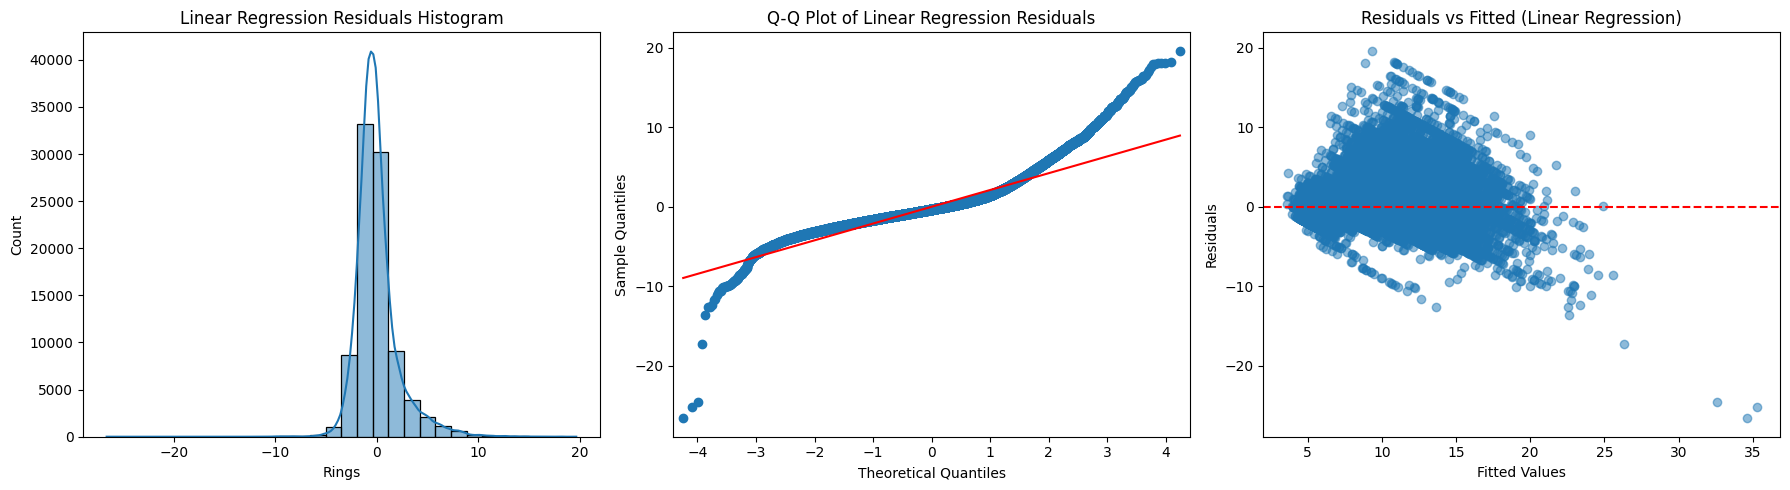

In [15]:
# Plot residual diagnostics for Linear Regression
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuals histogram
sns.histplot(residuals_lin, kde=True, ax=axes[0], bins=30)
axes[0].set_title("Linear Regression Residuals Histogram")

# Q-Q plot
sm.qqplot(residuals_lin, line='s', ax=axes[1])
axes[1].set_title("Q-Q Plot of Linear Regression Residuals")

# Residuals vs Fitted
axes[2].scatter(y_pred_lin, residuals_lin, alpha=0.5)
axes[2].axhline(y=0, color='red', linestyle='--')
axes[2].set_xlabel("Fitted Values")
axes[2].set_ylabel("Residuals")
axes[2].set_title("Residuals vs Fitted (Linear Regression)")

plt.tight_layout()
plt.show()

The histogram (left panel) shows that the residuals are centered around 0, which is good. However, there is a noticeable skew and heavier tails, especially on the right (positive residuals). This suggests departures from normality, particularly with some extreme residual values.

The Q-Q plot (middle panel) shows the middle portion of the distribution follows the straight line (normal). However, the deviations in both tails (left and right) indicate non-normality, with heavy-tailed residuals. This confirms the histogram insight. Therefore, the assumption of normality is violated, particularly in the tails which is a common issue with integer/count targets like Rings.

The residuals vs. fitted plot (right panel), shows a clear funnel shape where the residuals have a larger spread for lower fitted values and shrink as fitted values increase. This indicates heteroscedasticity because the variance of errors is not constant. A few large residuals are observed at higher predicted values, suggesting potential outliers or leverage points. The model violates homoscedasticity. The variance of residuals decreases with increasing fitted values.

Outliers and influential observations:
The Q-Q- plot and Residuals vs. Fitted plot both reveal some extreme residuals. Some points deviate beyond + or - 20 in residual scale, indicating potential outliers. There is no evidence of massive leverage effects visually, but furhter analysis (e.g., Cook's Distance) would confirm.
Overall there are likely some moderate to strong outliers.